# NEMPY Constraints Analysis

Jupyter Notebook <br>Version: 1.1 <br>Updated: 22/03/22 <br>
Author: Declan Heim <br>
Contact: [Email](mailto:d.heim@unsw.edu.au)<br>
GitHub Ref: [nempy_constraints_v1](https://github.com/dec-heim/nempy_constraints_v1)

---

## Introduction & Background

This notebook serves as an example of how constraints can be analysed using the open-source python simulator of AEMO's dispatch process, 'nempy'. This tool was initially developed by Nick Gorman and is expanded upon in this example, with additional functionality to draw insights into the impact of specific constraint equations in historical dispatch. These changes are not yet available via the official nempy release through pip, rather it draws on a forked version of the github repo. Updates to integrate and streamline these features into the official release of nempy are in progress.

The purpose of analysing constraints in this regard is to convey a deeper understanding and discussion around the impact of constraints to those units involved in the constraint. Further, this example demonstrates the outcomes that could be seen in the market by alleviating a specific constraint, both in a market price sense and the volume (MW) dispatched for each unit in the constraint. This type of analysis is possible by re-simulating the same dispatch interval and modifying the inputs that define the historically binding constraint. Such conterfactual work requires the use of a dispatch simulator, unlike higher-level observations which demonstrate the units have been constrained as opposed to what otherwise may have happened.

The example provided assumes the reader has some foundational understanding of the NEM dispatch process, how constraints are defined, the types of constraints and so forth. Hence it can be seen as an intermediate example. Explainations of historical dispatch procedures in nempy are omitted given there is abundant information [covered in this example](https://nempy.readthedocs.io/en/latest/examples.html#detailed-recreation-of-historical-dispatch). To gain a thorough understanding of the work presented here, one should first understand simplier examples of NEM dispatch and have some insight as to how nempy can be used, as provided in [Nempy Documentation.](https://nempy.readthedocs.io/) Some helpful resources to assist in understanding constraints in the NEM are linked below.

### Acknowledgement:
Special thanks to Nick Gorman at UNSW for developing the nempy tool and providing continued support in expanding it's functionality for the constraints analysis here. 

### Specific Notebook Context:
This specific example demonstrates a timeseries constraints analysis and follows a previous example on constraints [available here](https://github.com/dec-heim/Constraints-Analysis/blob/main/example_a.ipynb). I've omitted a fair amount of explaination here as it is covered in the earlier notebook. This example is somewhat more advanced so the reader should be well acquainted with constraints to digest the material here.

---

### Useful References:
<font color=blue>**Relevant nempy material:**</font>
- [UNSW-CEEM Nempy Github](https://github.com/UNSW-CEEM/nempy)
- [Nempy Documentation](https://nempy.readthedocs.io/)

<font color=blue>**Relevant nempy examples:**</font>
- [Nempy: Simple Examples 1-5](https://nempy.readthedocs.io/en/latest/examples.html#)
- [Nempy: Detailed Recreation of Historical Dispatch](https://nempy.readthedocs.io/en/latest/examples.html#detailed-recreation-of-historical-dispatch)

<font color=blue>**Relevant material for understanding constraints:**</font>
- [AEMO Constraint Implementation Guidelines (2015)](https://www.aemo.com.au/Electricity/National-Electricity-Market-NEM/Security-and-reliability/-/media/943DDD419E5942B8993CCA8EA201C37E.ashx)
- [AEMO Constraint Naming Guidelines (2013)](https://www.aemo.com.au/-/media/Files/Electricity/NEM/Security_and_Reliability/Congestion-Information/2016/Constraint-Naming-Guidelines.pdf)
- [Example of Marginal Value Calculations of 'X5' constraint, by Allan O'Neil (WattClarity)](https://wattclarity.com.au/articles/2020/12/casestudy-followup-x5-constraint/)

<font color=blue>**Specific material for the constraint that this example draws upon:**</font>
- [Example Analysis of Constraint Impact on PV, by Jack Simpson](https://jacksimpson.co/exploring-the-impact-of-constraints-on-a-solar-farm-in-the-national-electricity-market/)
- [AEMO Feb 2021 Monthly Constraint Report](https://www.aemo.com.au/-/media/files/electricity/nem/security_and_reliability/congestion-information/statistics/2021/monthly-constraint-report-february-2021.pdf?la=en).
---

## Example 2 - Investigating the impact of NSW Line 94T in Feb 2021 (Timeseries)
### Event Description
This example highlights historical events of the constrained line 94T representing Molong to Orange North in NSW during February 2021. Specifically this event  was noted earlier by [J. Simpson.](https://jacksimpson.co/exploring-the-impact-of-constraints-on-a-solar-farm-in-the-national-electricity-market/) and can further be found through AEMO's [monthly reporting process.](https://www.aemo.com.au/-/media/files/electricity/nem/security_and_reliability/congestion-information/statistics/2021/monthly-constraint-report-february-2021.pdf?la=en)


Specific details of which units are involved in the constraint is provided in the latter sections of this notebook, demonstrating how such information can be extracted from nempy. In the meantime, we can contextualise this constraint as having a signficant impact on a number of solar farms located in Central-West NSW as flagged by the earlier references. **Noting this second example looks into the timeseries across the day as opposed to a single dispatch interval.**

---

## Section A. Model Building
### A1. Import Python Packages


In [1]:
import pandas as pd
!pip install db-sqlite3
import sqlite3

# The forked nempy market dispatch engine is loaded
!pip install --user --upgrade git+https://github.com/dec-heim/nempy_constraints_v1.git --no-warn-script-location
from nempy import markets, time_sequential
from nempy.historical_inputs import loaders, mms_db, \
    xml_cache, units, demand, interconnectors, constraints

from datetime import datetime, timedelta

!pip install git+https://github.com/jmcnamara/XlsxWriter
import xlsxwriter

# Plotting packages
!pip install plotly kaleido
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/dec-heim/nempy_constraints_v1.git to c:\users\derlu\appdata\local\temp\pip-req-build-8r3zmwk0
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for nempy: filename=nempy-1.1.3-py3-none-any.whl size=103611 sha256=b08a0d3aae05790e51e81b8c1e2236e155986f975042a33755836ca9fb210d55
  Stored in directory: C:\Users\derlu\AppData\Local\Temp\pip-ephem-wheel-cache-knjrff5g\wheels\d3\0b\4b\3534317cafbfa13bcf2ed9787af57d0f8f5126ec001809f0ea
Successfully built nempy
  Attempting uninstall: nempy
    Found existing installation: nempy 1.1.3
    Uninstalling nempy-1.1.3:
      Successfully uninstalled nempy-1.1.3
Defaulting

---

### A2. Retrieve + Prepare Historical Data from AEMO

The data for this example has already been extracted and prepared for nempy locally. The data was found for the **15th February 2021** as described in the previous examples.

In [2]:
con = sqlite3.connect('feb_2021_mms.db')
mms_db_manager = mms_db.DBManager(connection=con)
xml_cache_manager = xml_cache.XMLCacheManager('feb_2021_cache')

raw_inputs_loader = loaders.RawInputsLoader(
    nemde_xml_cache_manager=xml_cache_manager,
    market_management_system_database=mms_db_manager)

---

### A3. Define Dispatch Intervals
Building on the previous constraints example, we are now interested to see the impact of a specific constraint across multiple dispatch intervals (a timeseries analysis).

Here we define functions to generate a list of 5-minute dispatch intervals to later input to nempy.

In [3]:
def perdelta(start_date, end_date, min_interval):
    """
    Function accessed by create_dispatch_list. Generates List of Datetimes between 2 dates.
    perdelta SourceCode retrieved and modified from: 
    https://stackoverflow.com/questions/10688006/generate-a-list-of-datetimes-between-an-interval
    """
    start = datetime.strptime(start_date,'%Y/%m/%d %H:%M:%S')    
    end = datetime.strptime(end_date,'%Y/%m/%d %H:%M:%S')  
    delta = timedelta(minutes=min_interval)
    
    curr = start
    while curr <= end:
        yield curr
        curr += delta

def create_dispatch_list(start_date, end_date, min_interval=5):
    """
    Generates a list of dispatch intervals between two dates.
    Inputs: start_date, end_date >> passed as string
    """
    result = []
    for n in perdelta(start_date, end_date, min_interval):
        result = result + [datetime.strftime(n,'%Y/%m/%d %H:%M:%S')]
    return result

In [4]:
dispatch_intervals = create_dispatch_list('2021/02/15 06:00:00','2021/02/15 18:05:00')
di_df = pd.DataFrame(dispatch_intervals, columns=['di_list'])
di_df

,di_list
0,2021/02/15 06:00:00
1,2021/02/15 06:05:00
2,2021/02/15 06:10:00
3,2021/02/15 06:15:00
4,2021/02/15 06:20:00
...,...
141,2021/02/15 17:45:00
142,2021/02/15 17:50:00
143,2021/02/15 17:55:00
144,2021/02/15 18:00:00


---
### A4. Define Market Data & Economic Dispatch Process
A more detailed explaination of what is happening here can be found in the earlier constraints example. Defining a function allows us to iterate this procedure later. Noting a slight addition before the <code>market.dispatch()</code> is called we ensure that if a constraint name is provided, then it is removed in the economic dispatch procedure via the function <code>market.remove_generic_constraint_set()</code>.

We also have created some lists to convieniently store output data.

In [5]:
outputs, outputs_mvs, outputs_prices, outputs_units = [],[],[],[]

def economic_dispatch(interval, remove_constraint_name=None):
    
    raw_inputs_loader.set_interval(interval)
    unit_inputs = units.UnitData(raw_inputs_loader)
    interconnector_inputs = interconnectors.InterconnectorData(raw_inputs_loader)
    constraint_inputs = constraints.ConstraintData(raw_inputs_loader)
    demand_inputs = demand.DemandData(raw_inputs_loader)

    # Define market, unit info
    unit_info = unit_inputs.get_unit_info()
    market = markets.SpotMarket(market_regions=['QLD1', 'NSW1', 'VIC1',
                                                'SA1', 'TAS1'],
                                unit_info=unit_info)

    # Set volume, price bids
    volume_bids, price_bids = unit_inputs.get_processed_bids()
    market.set_unit_volume_bids(volume_bids)
    market.set_unit_price_bids(price_bids)

    # Set bid in capacity limits
    unit_bid_limit = unit_inputs.get_unit_bid_availability()
    market.set_unit_bid_capacity_constraints(unit_bid_limit)
    cost = constraint_inputs.get_constraint_violation_prices()['unit_capacity']
    market.make_constraints_elastic('unit_bid_capacity', violation_cost=cost)

    # Set limits provided by the unconstrained intermittent generation
    # forecasts. Primarily for wind and solar.
    unit_uigf_limit = unit_inputs.get_unit_uigf_limits()
    market.set_unconstrained_intermitent_generation_forecast_constraint(
        unit_uigf_limit)
    cost = constraint_inputs.get_constraint_violation_prices()['uigf']
    market.make_constraints_elastic('uigf_capacity', violation_cost=cost)

    # Set unit ramp rates.
    ramp_rates = unit_inputs.get_ramp_rates_used_for_energy_dispatch()
    market.set_unit_ramp_up_constraints(
        ramp_rates.loc[:, ['unit', 'initial_output', 'ramp_up_rate']])
    market.set_unit_ramp_down_constraints(
        ramp_rates.loc[:, ['unit', 'initial_output', 'ramp_down_rate']])
    cost = constraint_inputs.get_constraint_violation_prices()['ramp_rate']
    market.make_constraints_elastic('ramp_up', violation_cost=cost)
    market.make_constraints_elastic('ramp_down', violation_cost=cost)

    # Set unit FCAS trapezium constraints.
    unit_inputs.add_fcas_trapezium_constraints()
    cost = constraint_inputs.get_constraint_violation_prices()['fcas_max_avail']
    fcas_availability = unit_inputs.get_fcas_max_availability()
    market.set_fcas_max_availability(fcas_availability)
    market.make_constraints_elastic('fcas_max_availability', cost)
    cost = constraint_inputs.get_constraint_violation_prices()['fcas_profile']
    regulation_trapeziums = unit_inputs.get_fcas_regulation_trapeziums()
    market.set_energy_and_regulation_capacity_constraints(regulation_trapeziums)
    market.make_constraints_elastic('energy_and_regulation_capacity', cost)
    scada_ramp_down_rates = unit_inputs.get_scada_ramp_down_rates_of_lower_reg_units()
    market.set_joint_ramping_constraints_lower_reg(scada_ramp_down_rates)
    market.make_constraints_elastic('joint_ramping_lower_reg', cost)
    scada_ramp_up_rates = unit_inputs.get_scada_ramp_up_rates_of_raise_reg_units()
    market.set_joint_ramping_constraints_raise_reg(scada_ramp_up_rates)
    market.make_constraints_elastic('joint_ramping_raise_reg', cost)
    contingency_trapeziums = unit_inputs.get_contingency_services()
    market.set_joint_capacity_constraints(contingency_trapeziums)
    market.make_constraints_elastic('joint_capacity', cost)

    # Set interconnector definitions, limits and loss models.
    interconnectors_definitions = \
        interconnector_inputs.get_interconnector_definitions()
    loss_functions, interpolation_break_points = \
        interconnector_inputs.get_interconnector_loss_model()
    market.set_interconnectors(interconnectors_definitions)
    market.set_interconnector_losses(loss_functions,
                                      interpolation_break_points)

    # Add FCAS market constraints.
    fcas_requirements = constraint_inputs.get_fcas_requirements()
    market.set_fcas_requirements_constraints(fcas_requirements)
    violation_costs = constraint_inputs.get_violation_costs()
    market.make_constraints_elastic('fcas', violation_cost=violation_costs) 

    # Add generic constraints, RHS parameters
    generic_rhs = constraint_inputs.get_rhs_and_type_excluding_regional_fcas_constraints()
    market.set_generic_constraints(generic_rhs)
    market.make_constraints_elastic('generic', violation_cost=violation_costs)
    
    # Add generic constraints, LHS coefficients DUIDs
    unit_generic_lhs = constraint_inputs.get_unit_lhs()
    market.link_units_to_generic_constraints(unit_generic_lhs)
    
    # Add generic constraints, LHS coeffients ICs
    interconnector_generic_lhs = constraint_inputs.get_interconnector_lhs()
    market.link_interconnectors_to_generic_constraints(
        interconnector_generic_lhs)
    
    # Set the operational demand to be met by dispatch.
    regional_demand = demand_inputs.get_operational_demand()
    market.set_demand_constraints(regional_demand)
    
    # Check to remove constraint set
    if remove_constraint_name is not None:
        for constraint in remove_constraint_name:
            market.remove_generic_constraint_set(constraint)
    
    # Run market dispatch
    market.dispatch()
    
    # Retrieve & Save market data
    result_mv = market.get_constraint_marginal_values()
    result_mv.insert(0,'interval',interval)

    result_units = market.get_unit_dispatch()
    result_units.insert(0,'interval',interval)
    
    result_prices = market.get_energy_prices()
    result_prices.insert(0,'interval',interval)

    return {'marginal_values': result_mv, 'unit_dispatch': result_units, 'energy_prices': result_prices}

---
## Section B - Running Market Dispatch across timeseries
### B1. Initial Results
Importantly, we are now interested in observing what is happening throughout the day across multiple dispatch intervals and the overall impact of the constraint under investigation on unit dispatch and market prices. At this stage, the first iteration across the timeseries includes all historical constraints.

In [6]:
for di in di_df['di_list']:
    outputs = economic_dispatch(di)
    outputs_mvs += [outputs['marginal_values']]
    outputs_units += [outputs['unit_dispatch']]
    outputs_prices += [outputs['energy_prices']]

marginal_values = pd.concat(outputs_mvs)
unit_dispatch = pd.concat(outputs_units)
prices = pd.concat(outputs_prices)

print("Dispatch Simulation Complete")

Dispatch Simulation Complete


---
### B2. Simulated Market Prices
Tablulating the price results we can later compare the impact of the specific constraint on market prices. The full dataframe is accesible via a downloaded excel file at the end of this notebook.

**Tabulated Price Results**

In [7]:
prices_table = prices.groupby(['region','interval']).price.first().unstack()
prices_table

interval,2021/02/15 06:00:00,2021/02/15 06:05:00,2021/02/15 06:10:00,2021/02/15 06:15:00,2021/02/15 06:20:00,2021/02/15 06:25:00,2021/02/15 06:30:00,2021/02/15 06:35:00,2021/02/15 06:40:00,2021/02/15 06:45:00,...,2021/02/15 17:20:00,2021/02/15 17:25:00,2021/02/15 17:30:00,2021/02/15 17:35:00,2021/02/15 17:40:00,2021/02/15 17:45:00,2021/02/15 17:50:00,2021/02/15 17:55:00,2021/02/15 18:00:00,2021/02/15 18:05:00
region,,,,,,,,,,,,,,,,,,,,,
NSW1,37.128317,35.480000,35.480000,35.470000,35.480000,35.480000,37.262931,37.539484,37.222093,35.470000,...,36.142973,36.067103,35.617971,35.480000,35.842109,36.175748,35.580000,49.220000,52.605351,38.265085
QLD1,38.900000,37.124287,36.396962,36.682978,36.444699,35.616770,37.730000,37.730000,37.730000,35.406946,...,37.386470,37.314017,37.143988,37.576261,38.258477,38.900000,38.548054,52.145162,55.730000,41.470000
SA1,32.736256,32.104579,32.019084,32.009874,32.462971,32.964412,35.382052,36.950017,37.016680,35.350532,...,38.031225,38.612664,38.191360,38.772997,38.761503,39.407664,39.505089,55.359105,58.103616,42.463455
TAS1,39.881000,38.581000,38.581000,38.581000,40.205455,43.641044,53.210000,60.160000,57.960000,60.160000,...,36.964312,39.517000,39.517000,37.848780,37.268780,39.517000,40.783248,52.169272,53.692700,38.988223
VIC1,32.683259,31.934547,31.967247,31.958052,32.303594,32.622727,34.606221,35.622464,35.700290,34.115011,...,34.960000,34.960000,34.960000,34.960000,34.960000,35.004952,34.960000,48.705042,51.129443,37.578004


---

### B3. Binding Constraint Results
The below produces a very useful table showing all constraints that have binded at some stage during the timeseries. Each column displays the marginal value for the specific interval, where NaN (or zero) indicates that the constraint did not bind during that interval.

Not also that some constraints may have a dynamic RHS that is not necessarily fixed, however we haven't captured this level of detail here. The consequent change in marginal value that may be due to the dynamic rhs changing as opposed to the lhs arguments is not known here.

In [8]:
mv_table = marginal_values.groupby(['set','interval']).marginal_value.first().unstack().fillna(0).round(1)
mv_table

interval,2021/02/15 06:00:00,2021/02/15 06:05:00,2021/02/15 06:10:00,2021/02/15 06:15:00,2021/02/15 06:20:00,2021/02/15 06:25:00,2021/02/15 06:30:00,2021/02/15 06:35:00,2021/02/15 06:40:00,2021/02/15 06:45:00,...,2021/02/15 17:20:00,2021/02/15 17:25:00,2021/02/15 17:30:00,2021/02/15 17:35:00,2021/02/15 17:40:00,2021/02/15 17:45:00,2021/02/15 17:50:00,2021/02/15 17:55:00,2021/02/15 18:00:00,2021/02/15 18:05:00
set,,,,,,,,,,,,,,,,,,,,,
#MWPS1PV1_E,-1032.7,0.0,0.0,-1032.0,-1032.5,-1033.0,-1035.4,-1037.0,0.0,-1035.4,...,0.0,-1038.6,0.0,0.0,0.0,0.0,-1039.5,0.0,0.0,-1042.5
#MWPS2PV1_E,0.0,0.0,0.0,-1032.0,-1032.5,-1033.0,-1035.4,0.0,-1037.0,0.0,...,0.0,0.0,-1038.2,-1038.8,-1038.8,0.0,0.0,-1055.4,-1058.1,-1042.5
#MWPS4PV1_E,0.0,-1032.1,-1032.0,0.0,0.0,0.0,-1035.4,0.0,0.0,0.0,...,-1038.0,0.0,0.0,-1038.8,0.0,-1039.4,0.0,-1055.4,-1058.1,0.0
#PPCCGT_D_E,14967.3,14967.9,14968.0,14968.0,14967.5,14967.0,14964.6,14963.0,14963.0,14964.6,...,14962.0,14961.4,14961.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#TORRB1_D_E,14967.3,14967.9,14968.0,14968.0,14967.5,14967.0,14964.6,14963.0,14963.0,14964.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#TORRB3_D_E,14967.3,14967.9,14968.0,14968.0,14967.5,14967.0,14964.6,14963.0,14963.0,14964.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#WARWSF1_E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#YATSF1_E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
$BARRON-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Retrieve information about the 'N>>N-NIL_94T_947' constraint
Specifically, we are interested in the impact of removing the <b>N>>N-NIL_94T_947</b> constraint, as per the previous example however now looking across the timeseries of dispatch intervals. From which we can compare the earlier analysis of this occurance in the [Example by J. Simpson](https://jacksimpson.co/exploring-the-impact-of-constraints-on-a-solar-farm-in-the-national-electricity-market/)

Here we can note the change in marginal values across the timeseries

In [9]:
con_vals = mv_table.loc['N>>N-NIL_94T_947',:]
con_vals_nonzero = con_vals[con_vals != 0]
pd.DataFrame(con_vals_nonzero)

,N>>N-NIL_94T_947
interval,
2021/02/15 07:20:00,-52.2
2021/02/15 07:25:00,-49.6
2021/02/15 07:30:00,-50.0
2021/02/15 07:35:00,-48.0
2021/02/15 07:55:00,-471.7
...,...
2021/02/15 15:35:00,-476.5
2021/02/15 15:40:00,-498.6
2021/02/15 15:45:00,-522.9


---

### B4. Unit Dispatch Results
For completeness, we can also tabulate the unit dispatch results here. Specifically, we are only interested in the energy service not FCAS here. These are further saved in the downloaded results file.

In [10]:
unit_dispatch = unit_dispatch[unit_dispatch['service'] == 'energy']

units_table = unit_dispatch.groupby(['unit','interval']).dispatch.first().unstack().round(1)
units_table

interval,2021/02/15 06:00:00,2021/02/15 06:05:00,2021/02/15 06:10:00,2021/02/15 06:15:00,2021/02/15 06:20:00,2021/02/15 06:25:00,2021/02/15 06:30:00,2021/02/15 06:35:00,2021/02/15 06:40:00,2021/02/15 06:45:00,...,2021/02/15 17:20:00,2021/02/15 17:25:00,2021/02/15 17:30:00,2021/02/15 17:35:00,2021/02/15 17:40:00,2021/02/15 17:45:00,2021/02/15 17:50:00,2021/02/15 17:55:00,2021/02/15 18:00:00,2021/02/15 18:05:00
unit,,,,,,,,,,,,,,,,,,,,,
AGLHAL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AGLSOM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ANGAST1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ARWF1,112.4,105.9,100.1,104.7,103.6,111.4,99.2,95.0,89.7,94.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BALBG1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YENDWF1,61.4,65.8,61.0,52.0,52.6,47.3,52.8,55.6,58.3,55.5,...,18.6,18.9,17.6,19.3,17.8,17.9,17.6,18.8,18.1,16.5
YWPS1,380.0,380.0,380.0,380.0,380.0,380.0,380.0,380.0,380.0,380.0,...,370.0,370.0,370.0,370.0,370.0,370.0,370.0,370.0,370.0,375.0
YWPS2,350.0,350.0,350.0,350.0,350.0,350.0,350.0,350.0,350.0,350.0,...,350.0,350.0,350.0,350.0,350.0,350.0,350.0,350.0,350.0,350.0


---
## Section C - Rerun dispatch with constraint removed
### C1. Dispatch Simulation
Re-runing the earlier economic dispatch loop, however with the <code>remove_constraint_name</code> variable set to **'N>>N-NIL_94T_947'** yields a new set of results. Noting the <font color=purple>**_r**</font> designation to each variable indicating the dispatch with the constriant removed.

Unsuprisingly (or perhaps even suprisingly) after the **'N>>N-NIL_94T_947'** constraint is removed, the **'N>>N-NIL_94T'** constraint then binds. Given this is the same line 94T being considered which is thermally constrained, and for somewhat illustrative purposes both are removed here.

In [11]:
#Clear output lists
outputs, outputs_mvs, outputs_units, outputs_prices = [],[],[],[]

for di in dispatch_intervals:
    outputs = economic_dispatch(di,remove_constraint_name=['N>>N-NIL_94T_947','N>>N-NIL_94T'])
    outputs_mvs += [outputs['marginal_values']]
    outputs_units += [outputs['unit_dispatch']]
    outputs_prices += [outputs['energy_prices']]

marginal_values_r = pd.concat(outputs_mvs)
unit_dispatch_r = pd.concat(outputs_units)
prices_r = pd.concat(outputs_prices)

print("Dispatch Simulation Complete")

Dispatch Simulation Complete


---
### C2. Simulated Market Prices
Tablulating the price results we can compare with the earlier results. The full dataframe is accesible via a downloaded excel file at the end of this notebook.

**Tabulated Price Results**

In [12]:
prices_table_r = prices_r.groupby(['region','interval']).price.first().unstack()
prices_table_r

interval,2021/02/15 06:00:00,2021/02/15 06:05:00,2021/02/15 06:10:00,2021/02/15 06:15:00,2021/02/15 06:20:00,2021/02/15 06:25:00,2021/02/15 06:30:00,2021/02/15 06:35:00,2021/02/15 06:40:00,2021/02/15 06:45:00,...,2021/02/15 17:20:00,2021/02/15 17:25:00,2021/02/15 17:30:00,2021/02/15 17:35:00,2021/02/15 17:40:00,2021/02/15 17:45:00,2021/02/15 17:50:00,2021/02/15 17:55:00,2021/02/15 18:00:00,2021/02/15 18:05:00
region,,,,,,,,,,,,,,,,,,,,,
NSW1,37.128317,35.480000,35.480000,35.470000,35.480000,35.480000,37.262931,37.539484,37.222093,35.470000,...,36.142973,36.067103,35.617971,35.480000,35.842109,36.175748,35.580000,49.220000,52.605351,38.265085
QLD1,38.900000,37.124287,36.396962,36.682978,36.444699,35.616770,37.730000,37.730000,37.730000,35.406946,...,37.386470,37.314017,37.143988,37.576261,38.258477,38.900000,38.548054,52.145162,55.730000,41.470000
SA1,32.736256,32.104579,32.019084,32.009874,32.462971,32.964412,35.382052,36.950017,37.016680,35.350532,...,38.031225,38.612664,38.191360,38.772997,38.761503,39.407664,39.505089,55.359105,58.103616,42.463455
TAS1,39.881000,38.581000,38.581000,38.581000,40.205455,43.641044,53.210000,60.160000,57.960000,60.160000,...,36.964312,39.517000,39.517000,37.848780,37.268780,39.517000,40.783248,52.169272,53.692700,38.988223
VIC1,32.683259,31.934547,31.967247,31.958052,32.303594,32.622727,34.606221,35.622464,35.700290,34.115011,...,34.960000,34.960000,34.960000,34.960000,34.960000,35.004952,34.960000,48.705042,51.129443,37.578004


---

### C3. Binding Constraint Results
Similarly, producing the new marginal value results for the second iteration of economic dispatch simulation...

In [13]:
mv_table_r = marginal_values_r.groupby(['set','interval']).marginal_value.first().unstack().fillna(0).round(1)
mv_table_r

interval,2021/02/15 06:00:00,2021/02/15 06:05:00,2021/02/15 06:10:00,2021/02/15 06:15:00,2021/02/15 06:20:00,2021/02/15 06:25:00,2021/02/15 06:30:00,2021/02/15 06:35:00,2021/02/15 06:40:00,2021/02/15 06:45:00,...,2021/02/15 17:20:00,2021/02/15 17:25:00,2021/02/15 17:30:00,2021/02/15 17:35:00,2021/02/15 17:40:00,2021/02/15 17:45:00,2021/02/15 17:50:00,2021/02/15 17:55:00,2021/02/15 18:00:00,2021/02/15 18:05:00
set,,,,,,,,,,,,,,,,,,,,,
#MWPS1PV1_E,-1032.7,-1032.1,0.0,-1032.0,-1032.5,0.0,0.0,0.0,0.0,-1035.4,...,0.0,-1038.6,-1038.2,0.0,-1038.8,0.0,-1039.5,0.0,0.0,0.0
#MWPS2PV1_E,0.0,0.0,0.0,0.0,0.0,0.0,-1035.4,-1037.0,0.0,-1035.4,...,-1038.0,0.0,0.0,0.0,-1038.8,-1039.4,-1039.5,-1055.4,0.0,0.0
#MWPS4PV1_E,0.0,-1032.1,-1032.0,-1032.0,0.0,-1033.0,0.0,0.0,-1037.0,0.0,...,0.0,-1038.6,0.0,0.0,-1038.8,0.0,-1039.5,0.0,0.0,-1042.5
#PPCCGT_D_E,14967.3,14967.9,14968.0,14968.0,14967.5,14967.0,14964.6,14963.0,14963.0,14964.6,...,14962.0,14961.4,14961.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#TORRB1_D_E,14967.3,14967.9,14968.0,14968.0,14967.5,14967.0,14964.6,14963.0,14963.0,14964.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#TORRB3_D_E,14967.3,14967.9,14968.0,14968.0,14967.5,14967.0,14964.6,14963.0,14963.0,14964.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#WARWSF1_E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#YATSF1_E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
$BARRON-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---

### C4. Unit Dispatch Results
Again, for unit dispatch...

In [14]:
unit_dispatch_r = unit_dispatch_r[unit_dispatch_r['service'] == 'energy']

units_table_r = unit_dispatch_r.groupby(['unit','interval']).dispatch.first().unstack().round(1)
units_table_r

interval,2021/02/15 06:00:00,2021/02/15 06:05:00,2021/02/15 06:10:00,2021/02/15 06:15:00,2021/02/15 06:20:00,2021/02/15 06:25:00,2021/02/15 06:30:00,2021/02/15 06:35:00,2021/02/15 06:40:00,2021/02/15 06:45:00,...,2021/02/15 17:20:00,2021/02/15 17:25:00,2021/02/15 17:30:00,2021/02/15 17:35:00,2021/02/15 17:40:00,2021/02/15 17:45:00,2021/02/15 17:50:00,2021/02/15 17:55:00,2021/02/15 18:00:00,2021/02/15 18:05:00
unit,,,,,,,,,,,,,,,,,,,,,
AGLHAL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AGLSOM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ANGAST1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ARWF1,112.4,105.9,100.1,104.7,103.6,111.4,99.2,95.0,89.7,94.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BALBG1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YENDWF1,61.4,65.8,61.0,52.0,52.6,47.3,52.8,55.6,58.3,55.5,...,18.6,18.9,17.6,19.3,17.8,17.9,17.6,18.8,18.1,16.5
YWPS1,380.0,380.0,380.0,380.0,380.0,380.0,380.0,380.0,380.0,380.0,...,370.0,370.0,370.0,370.0,370.0,370.0,370.0,370.0,370.0,375.0
YWPS2,350.0,350.0,350.0,350.0,350.0,350.0,350.0,350.0,350.0,350.0,...,350.0,350.0,350.0,350.0,350.0,350.0,350.0,350.0,350.0,350.0


---
## Section D - Results & Discussion
### D1. Price Variations
We can merge the previous results from Section B and C to compare the difference in prices for each region across the timeseries.

The first figure shows the cleared price for each interval in NSW with all constraints (blue), and with the Line 94T constraints removed.

The latter figure then shows the difference in price per region due to the removal of constraints. Here all values are either zero or negative, showing a reduction in the price by removing the constraints compared to the base case with all constraints considered.

In [15]:
prices_all = pd.merge(left=prices,right=prices_r,on=['interval','region'])
prices_all.rename(columns = {'price_x':'Price before','price_y':'Price after'},inplace=True)
prices_all['diff'] = prices_all['Price after'] - prices_all['Price before']

In [23]:
timeaxis = []
for item in prices_r['interval'].unique():
    timeaxis += [datetime.strptime(item, "%Y/%m/%d %H:%M:%S").time()]

In [26]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=timeaxis, y=prices[prices['region'] == 'NSW1']['price'], name='NSW price', mode='lines+markers',
                         marker_size=8, marker_symbol='circle'))
fig.add_trace(go.Scatter(x=timeaxis, y=prices_r[prices_r['region'] == 'NSW1']['price'], name='NSW price [r]', mode='lines+markers',
                         marker_size=8, marker_symbol='circle'))
fig.update_xaxes(title="Time")
fig.update_yaxes(title="Price ($/MWh)")
fig.update_layout(title="Figure 1: NSW Pool Price - Impact of 'N>>N-NIL_94T_947' & 'N>>N-NIL_94T' on 15/02/21<br><sup>[r] denotes constraint removed</sup>",
                 template="plotly_white")
fig.show()

In [29]:
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=timeaxis, y=prices_all[prices_all['region'] == 'NSW1']['diff'], name='NSW Δ Price', mode='lines+markers',
                         marker_size=8, marker_symbol='circle'))
fig2.add_trace(go.Scatter(x=timeaxis, y=prices_all[prices_all['region'] == 'QLD1']['diff'], name='QLD Δ Price', mode='lines+markers',
                         marker_size=8, marker_symbol='circle'))
fig2.add_trace(go.Scatter(x=timeaxis, y=prices_all[prices_all['region'] == 'VIC1']['diff'], name='VIC Δ Price', mode='lines+markers',
                         marker_size=8, marker_symbol='circle'))
fig2.add_trace(go.Scatter(x=timeaxis, y=prices_all[prices_all['region'] == 'SA1']['diff'], name='SA Δ Price', mode='lines+markers',
                         marker_size=8, marker_symbol='circle'))
fig2.add_trace(go.Scatter(x=timeaxis, y=prices_all[prices_all['region'] == 'TAS1']['diff'], name='TAS Δ Price', mode='lines+markers',
                         marker_size=8, marker_symbol='circle'))
fig2.update_xaxes(title="Time")
fig2.update_yaxes(title="Price ($/MWh)")
fig2.update_layout(title="Figure 2: All Region Change in Pool Prices due to 'N>>N-NIL_94T_947' & 'N>>N-NIL_94T' on 15/02/21<br><sup>[r] denotes constraint removed</sup>",
                  template="plotly_white")
fig2.show()

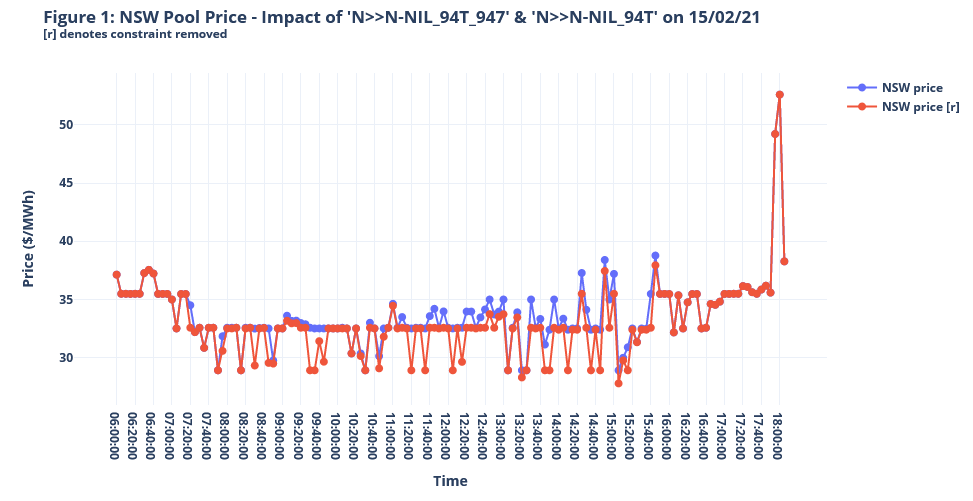
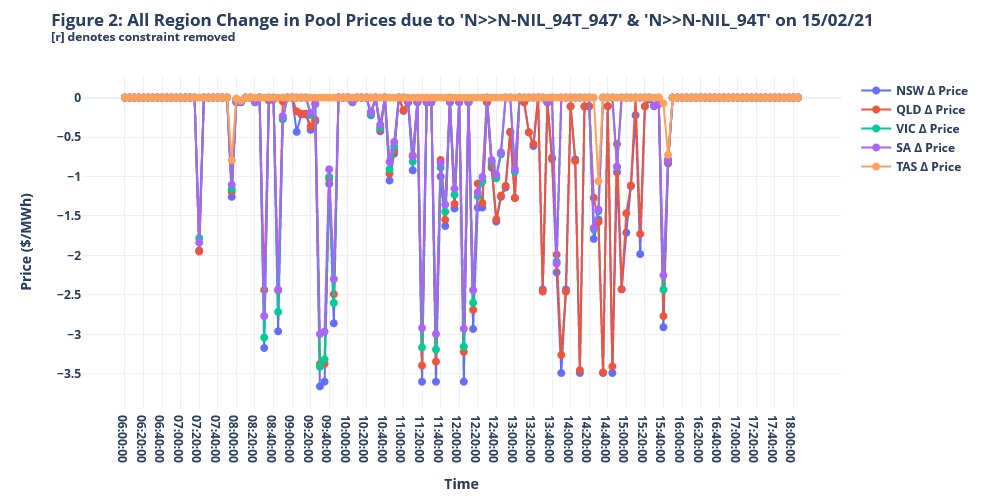

The first figure shows small variations in NSW price before and after removing the constraints however at first glance seems somewhat immaterial.

The latter figure capturing a broader impact on all regions given a change in the market. Although this line constraint is within NSW, with changes in dispatch there may be subsequent affects to other regions (a conversation for another day on analysing interconnectors).

---
### D2. Impact to specific units
Based on the previous example from a single dispatch interval, it was found that the constraint had a signficant impact on Beryl Solar Farm. The mappings have been omitted here but nonetheless, we shall dive deeper into Beryl SF.


In [30]:
fig3 = go.Figure()
fig3.add_trace(go.Scatter(x=timeaxis, y=unit_dispatch[unit_dispatch['unit'] == 'BERYLSF1']['dispatch'], name='BERYLSF1', mode='lines+markers',
                         marker_size=8, marker_symbol='circle',line_color='orange'))
fig3.add_trace(go.Scatter(x=timeaxis, y=unit_dispatch_r[unit_dispatch_r['unit'] == 'BERYLSF1']['dispatch'], name='BERYLSF1 [r]', mode='lines+markers',
                         marker_size=8, marker_symbol='circle',line_color='purple'))
fig3.update_xaxes(title="Time")
fig3.update_yaxes(title="Unit dispatch (MW)")
fig3.update_layout(title="Figure 3: Impact on Beryl SF dispatch by 'N>>N-NIL_94T_947' & N>>N-NIL_94T' on 15/02/21<br><sup>[r] denotes constraint removed</sup>",
                  template="plotly_white")
fig3.show()

In [31]:
fig4 = go.Figure()
fig4.add_trace(go.Scatter(x=timeaxis, y=unit_dispatch[unit_dispatch['unit'] == 'MANSLR1']['dispatch'], name='MANSLR1', mode='lines+markers',
                         marker_size=8, marker_symbol='circle',line_color='orange'))
fig4.add_trace(go.Scatter(x=timeaxis, y=unit_dispatch_r[unit_dispatch_r['unit'] == 'MANSLR1']['dispatch'], name='MANSLR1 [r]', mode='lines+markers',
                         marker_size=8, marker_symbol='circle',line_color='purple'))
fig4.update_xaxes(title="Time")
fig4.update_yaxes(title="Unit dispatch (MW)")
fig4.update_layout(title="Figure 4: Impact on Manildra SF dispatch by 'N>>N-NIL_94T_947' & N>>N-NIL_94T' on 15/02/21<br><sup>[r] denotes constraint removed</sup>",
                  template="plotly_white")
fig4.write_image("image-4.png")
fig4.show()

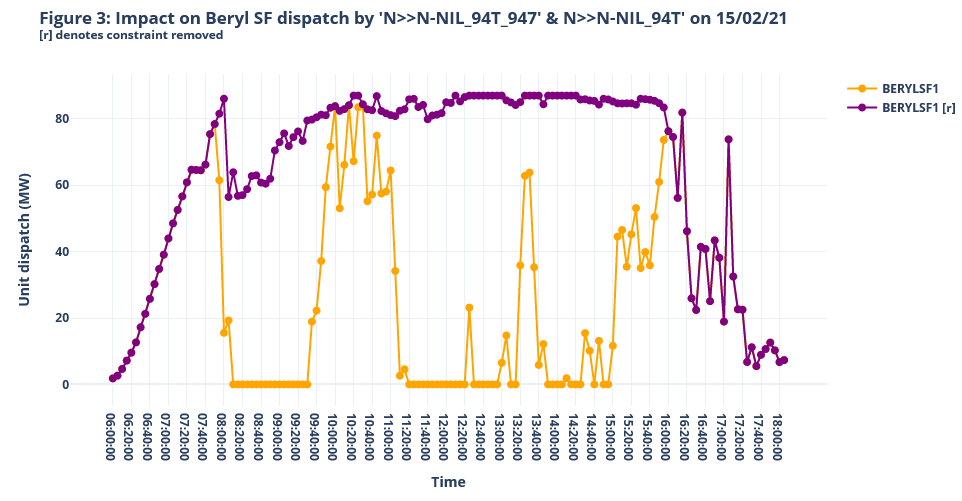
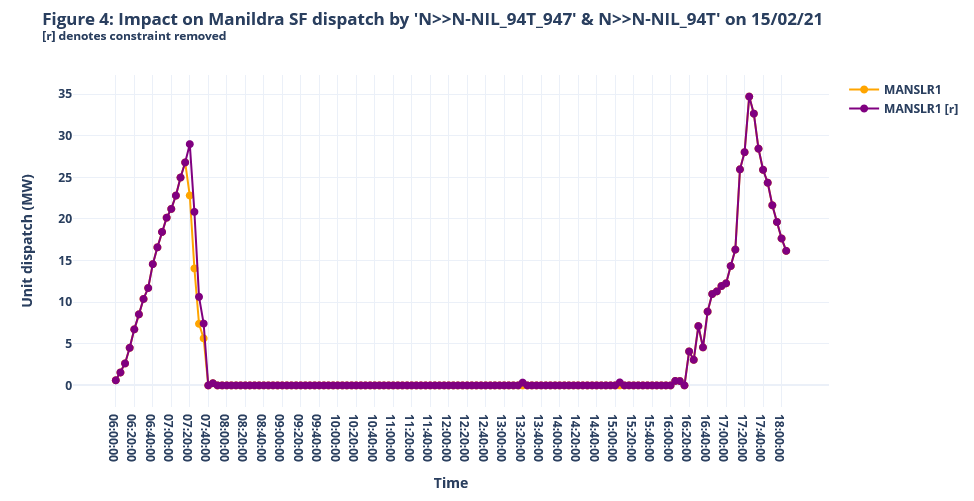

Figure 3 and Figure 4 captures the real crux of this type of constraints analysis using nempy. The impact of the specific line constraint for Beryl Solar Farm is profound throughout the majority of the day, at least the important hours where solar is available that is! However that cannot be said for Manildra. Despite being constrained signficantly, the cause of Manildra's curtailment cannot be attributed to 'N>>N-NIL_94T_947' & 'N>>N-NIL_94T' constraints. It is plausible (very much so) that another thermal line constraint in the vincinity is also binding... but we'll save this adventure for another time!

---
## Download Results

The excel file here is also available should it be of interest to look into specific numbers. A copy can be found in the constraints repository.

In [21]:
dflist = [prices_table.reset_index(), prices_table_r.reset_index(), mv_table.reset_index(), \
          mv_table_r.reset_index(), units_table.reset_index(), units_table_r.reset_index()]
dfnames = ['Base-Prices','ConRemoved-Prices','Base-MVs','ConRemoved-MVs','Base-Units','ConRemoved-Units']

Excelwriter = pd.ExcelWriter("results.xlsx",engine="xlsxwriter")
for i, df in enumerate (dflist):
    df.to_excel(Excelwriter, sheet_name=dfnames[i],index=False)
Excelwriter.save()

---
## Parting Words

This example of the timeseries builds on the previous explaination of using nempy for analysing constraints. It captures a tangible or visual sense of why constraints matter so much for specific units, here highlighting Beryl Solar Farm and Manildra Solar Farm as only one example of comparison. Such analysis is extremely insightful for anyone looking to gain a grasp on the uniqueness of constraints and subsequent impacts to specific generators or market outcomes at large.

If there's two cents to take from this, firstly finding the root cause for a specific plant to be constrained isn't necessarily easy... and secondly, not all units will behave in the same way when a constraint is removed... irrespective of their contribution (LHS coefficients) towards that constraint. Imagine how many constraints might be applied to that unit at any one time... (yep let's save that analysis for another day!) 

I hope this example proved to be benefiticial in one way or another. Feel free to reach out if you have any questions!